# Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import cufflinks as cf
from cufflinks.offline import go_offline
from plotly.offline import plot, iplot, init_notebook_mode, download_plotlyjs

# Data Collection

In [2]:
train_data = pd.read_excel('./Data/Data_Train.xlsx')

In [3]:
train_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


# Data Cleaning/Processing

First let's make a copy of the original data

In [5]:
data = train_data.copy()

## Missing Values

 Look for missing values

In [6]:
data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

Since there are only 2 missing values in the data set lets drop all records with null values

In [7]:
data.dropna(inplace=True)

In [8]:
data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

## Duplicates

In [9]:
data.duplicated().sum()

220

In [10]:
data.drop_duplicates(inplace=True)

In [11]:
data.duplicated().sum()

0

## Formatting

Let's format the ```Duration``` column

In [12]:
def preprocess_duration(x):
    if 'h' not in x:
        x = '0h' + ' ' + x
    elif 'm' not in x:
        x = x + ' ' + '0m'
    return x

In [13]:
data['Duration'] = data['Duration'].apply(preprocess_duration)


data['Duration_total_minutes'] = data['Duration'].str.replace('h','*60').str.replace(' ', '+').str.replace('m', '*1').apply(eval)
data['Duration_hour'] = data['Duration'].apply(lambda x: int(x.split(' ')[0][0:-1]))
data['Duration_minute'] = data['Duration'].apply(lambda x: int(x.split(' ')[1][0:-1]))

data.drop(columns='Duration',inplace=True)

## Dtype conversion

Noted a few columns that capture time information

In [14]:
def change_into_datetime(column):
    data[column] = pd.to_datetime(data[column])

In [15]:
for feature in ['Dep_Time','Arrival_Time','Date_of_Journey']:
    change_into_datetime(feature)

C:\Users\Devam\AppData\Local\Temp\ipykernel_10552\3112662709.py:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

C:\Users\Devam\AppData\Local\Temp\ipykernel_10552\3112662709.py:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

C:\Users\Devam\AppData\Local\Temp\ipykernel_10552\3112662709.py:2: UserWarning:

Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10462 entries, 0 to 10682
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Airline                 10462 non-null  object        
 1   Date_of_Journey         10462 non-null  datetime64[ns]
 2   Source                  10462 non-null  object        
 3   Destination             10462 non-null  object        
 4   Route                   10462 non-null  object        
 5   Dep_Time                10462 non-null  datetime64[ns]
 6   Arrival_Time            10462 non-null  datetime64[ns]
 7   Total_Stops             10462 non-null  object        
 8   Additional_Info         10462 non-null  object        
 9   Price                   10462 non-null  int64         
 10  Duration_total_minutes  10462 non-null  int64         
 11  Duration_hour           10462 non-null  int64         
 12  Duration_minute         10462 non-null  int64      

## Time extraction

In order for our machine learning algorithm to accurately proccess the influence of time on the target variable we must isolate the individual time components from the datetime features.

Let's create specific day, month, and year columns for ```Date_of_Journey```

In [17]:
data['Journey_day'] = data['Date_of_Journey'].dt.day
data['Journey_month'] = data['Date_of_Journey'].dt.month
data['Journey_year'] = data['Date_of_Journey'].dt.year

In [18]:
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Total_Stops,Additional_Info,Price,Duration_total_minutes,Duration_hour,Duration_minute,Journey_day,Journey_month,Journey_year
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,2024-08-16 22:20:00,2024-03-22 01:10:00,non-stop,No info,3897,170,2,50,24,3,2019
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,2024-08-16 05:50:00,2024-08-16 13:15:00,2 stops,No info,7662,445,7,25,1,5,2019
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,2024-08-16 09:25:00,2024-06-10 04:25:00,2 stops,No info,13882,1140,19,0,9,6,2019
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,2024-08-16 18:05:00,2024-08-16 23:30:00,1 stop,No info,6218,325,5,25,12,5,2019
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,2024-08-16 16:50:00,2024-08-16 21:35:00,1 stop,No info,13302,285,4,45,1,3,2019


Let's pull the hour and minute information from ```Dep_Time``` and ```Arrival_Time```

In [19]:
data['Dep_Time_hour'] = data['Dep_Time'].dt.hour
data['Dep_Time_minute'] = data['Dep_Time'].dt.minute

data['Arrival_Time_hour'] = data['Arrival_Time'].dt.hour
data['Arrival_Time_minute'] = data['Arrival_Time'].dt.minute

In [20]:
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Total_Stops,Additional_Info,Price,Duration_total_minutes,Duration_hour,Duration_minute,Journey_day,Journey_month,Journey_year,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,2024-08-16 22:20:00,2024-03-22 01:10:00,non-stop,No info,3897,170,2,50,24,3,2019,22,20,1,10
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,2024-08-16 05:50:00,2024-08-16 13:15:00,2 stops,No info,7662,445,7,25,1,5,2019,5,50,13,15
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,2024-08-16 09:25:00,2024-06-10 04:25:00,2 stops,No info,13882,1140,19,0,9,6,2019,9,25,4,25
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,2024-08-16 18:05:00,2024-08-16 23:30:00,1 stop,No info,6218,325,5,25,12,5,2019,18,5,23,30
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,2024-08-16 16:50:00,2024-08-16 21:35:00,1 stop,No info,13302,285,4,45,1,3,2019,16,50,21,35


Drop original columns

In [21]:
cols_to_drop = ['Date_of_Journey','Dep_Time','Arrival_Time']

data.drop(columns=cols_to_drop, inplace=True)

## Outliers

Let's take a quick look at our target variable ```Price``` to see if there are any outliers

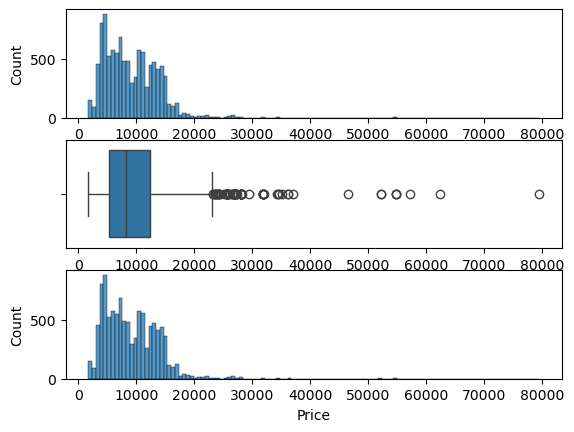

In [22]:
def plot(data, col):
    fig, ax= plt.subplots(nrows=3, ncols=1)
    
    sns.histplot(data[col], ax=ax[0])
    sns.boxplot(data[col],ax=ax[1], orient='h')
    sns.histplot(data[col],ax=ax[2], kde=False)

plot(data, 'Price')

In [23]:
q3 = data['Price'].quantile(0.75)
q1 = data['Price'].quantile(0.25)

iqr = q3-q1

maximum = q3 + 1.5*iqr
minmum = q1 - 1.5*iqr

len([price for price in data['Price'] if price > maximum or price < minmum])

94

Noted 94 outliers. Let's replace some these outliers with the median of ```Price``` since this distribution is right-skewed and the mean would be influenced by the outliers.

In [24]:
data['Price'] = np.where(data['Price'] > 35000, data['Price'].median(), data['Price'])

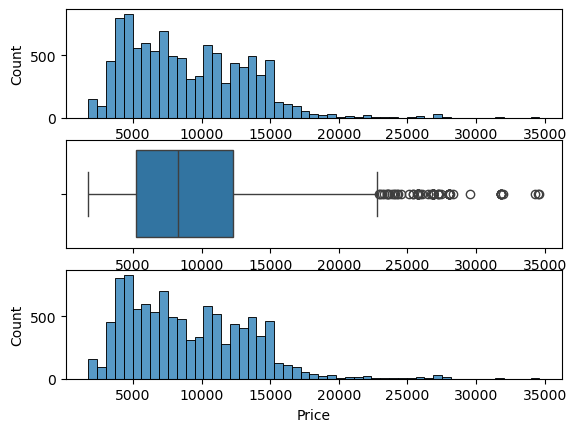

In [25]:
plot(data, 'Price')

# Data Analysis

In [26]:
categorical_columns = data.select_dtypes(include=['object'])
numerical_columns = data.select_dtypes(include=['number'])

In [27]:
init_notebook_mode(connected=True)
cf.go_offline()

Let's take a look at general distributions of the numerical features

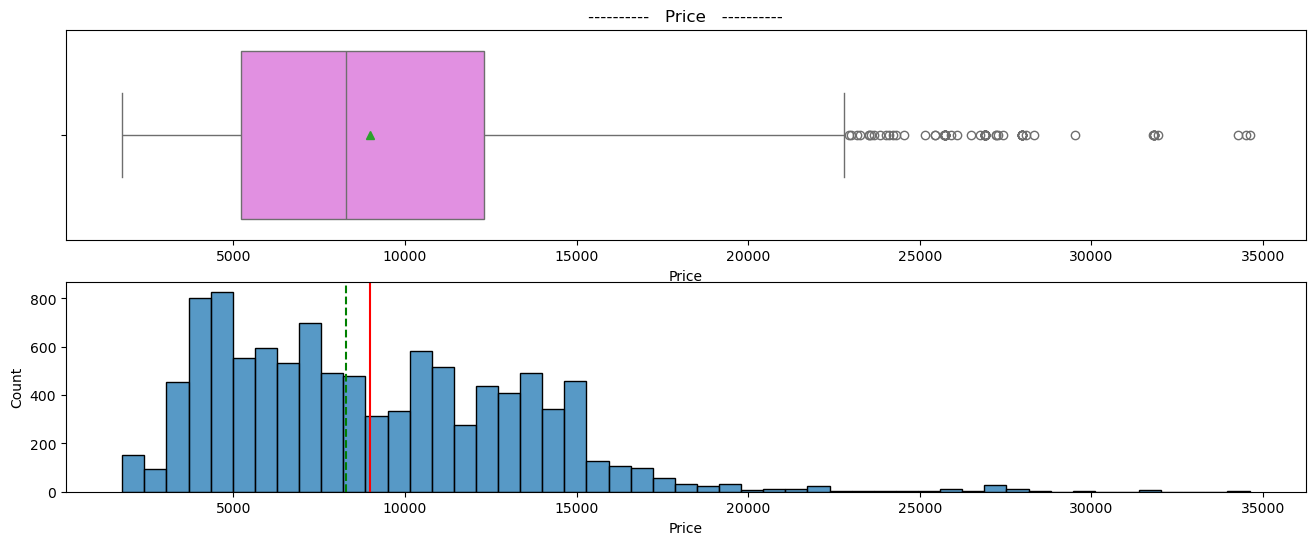

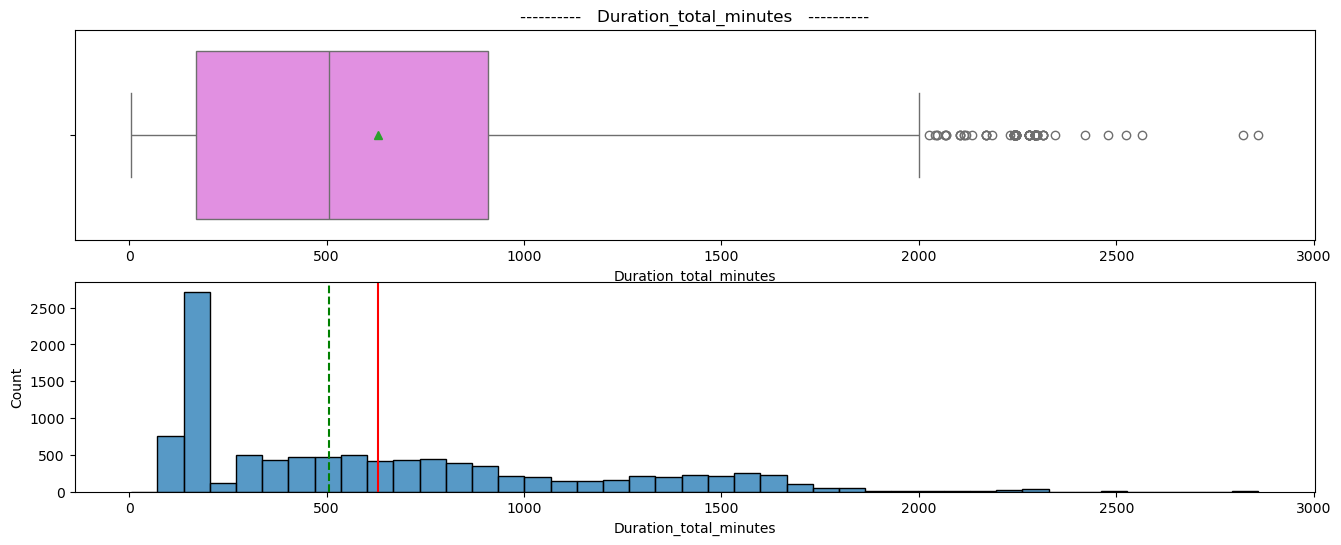

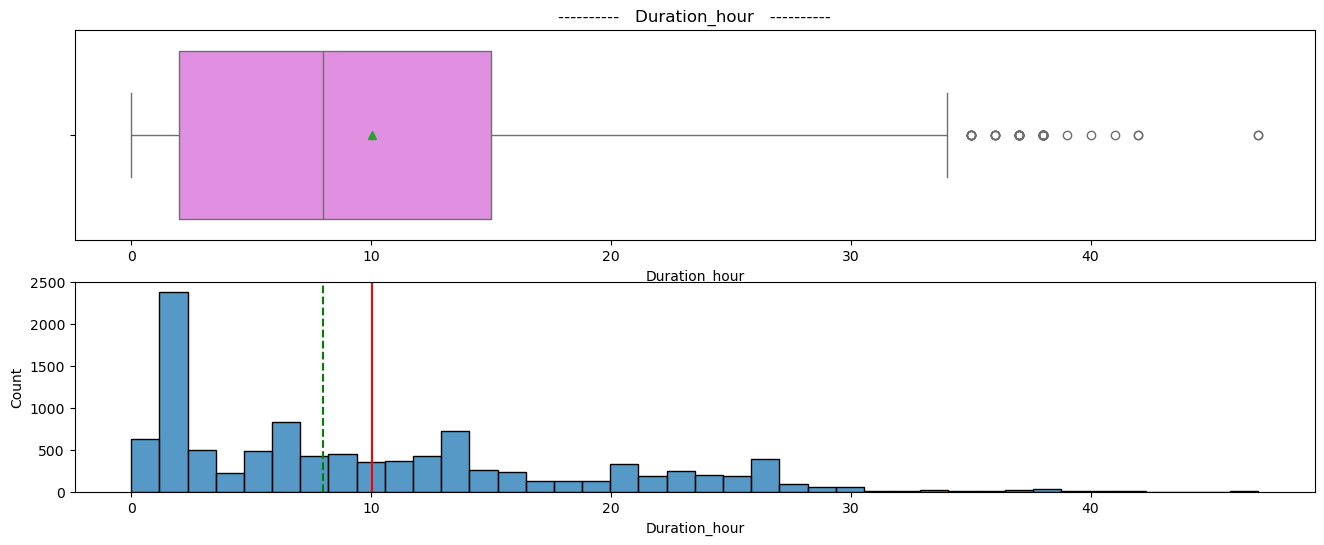

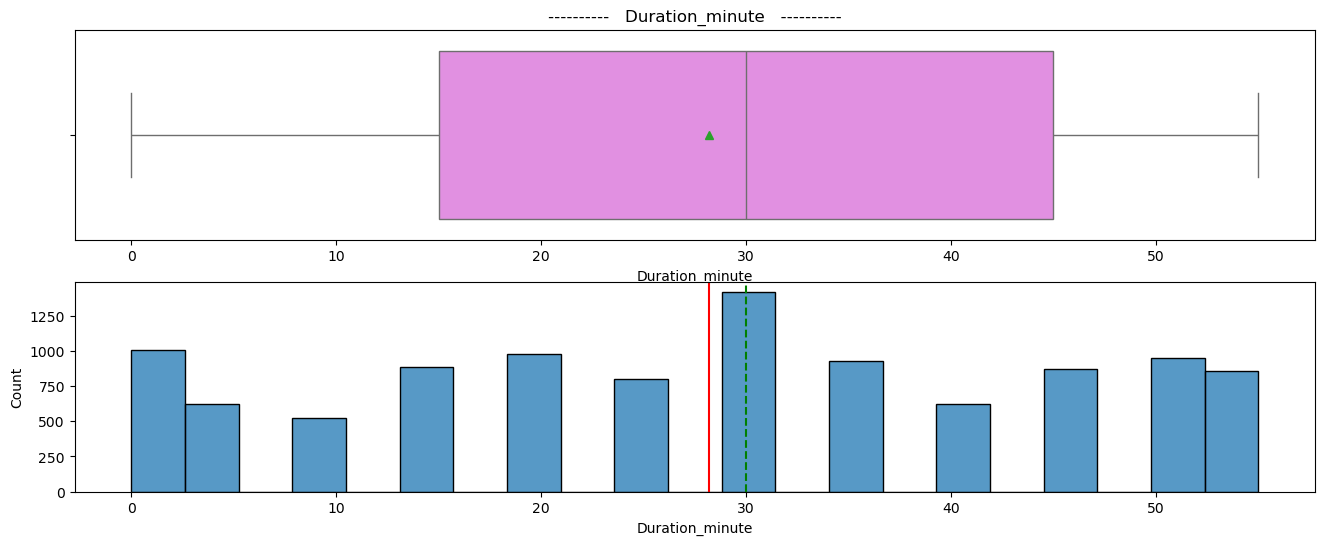

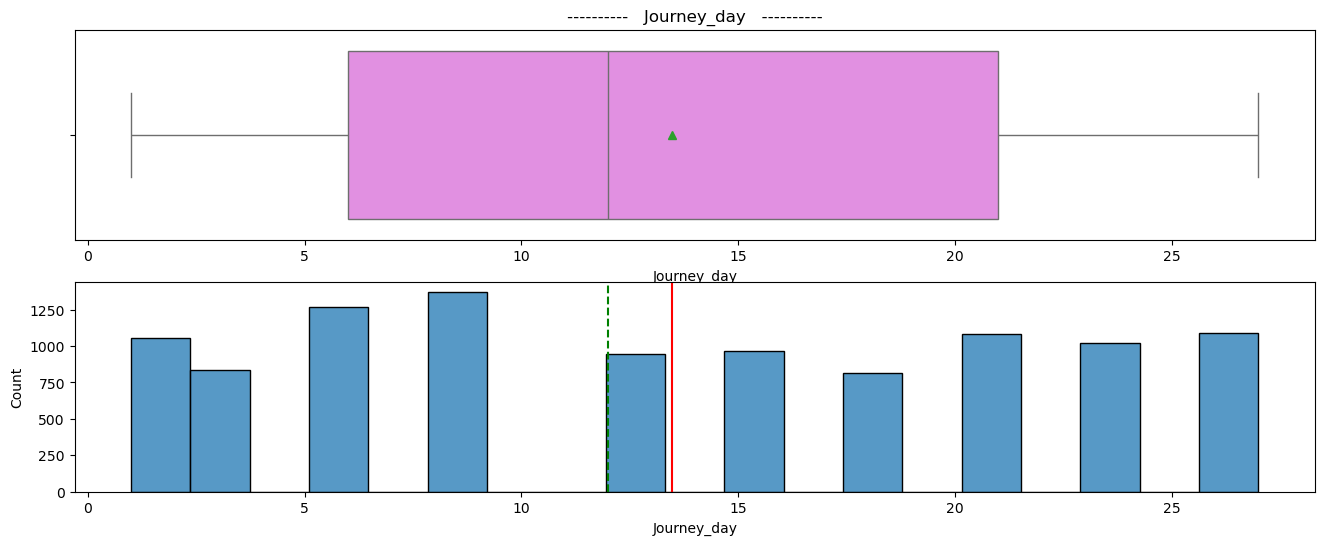

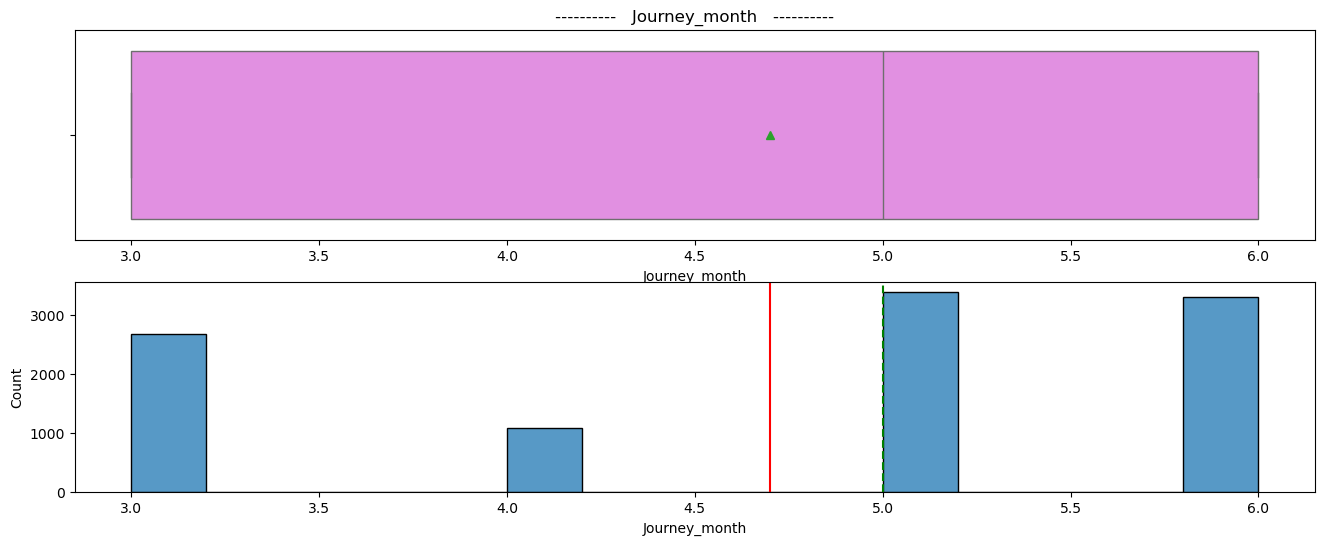

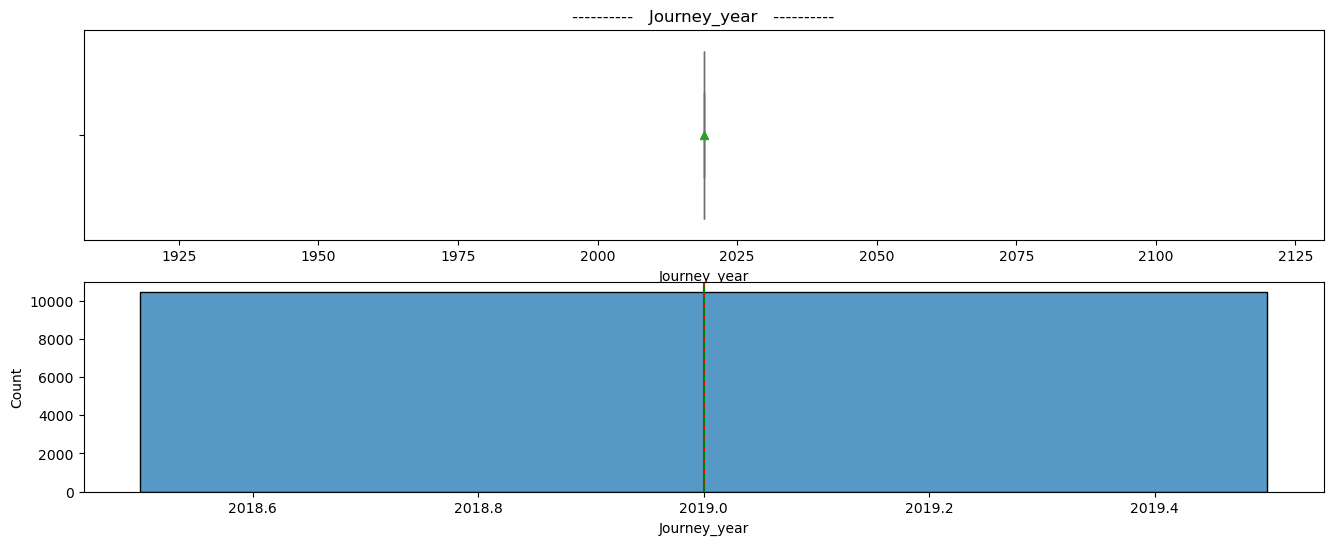

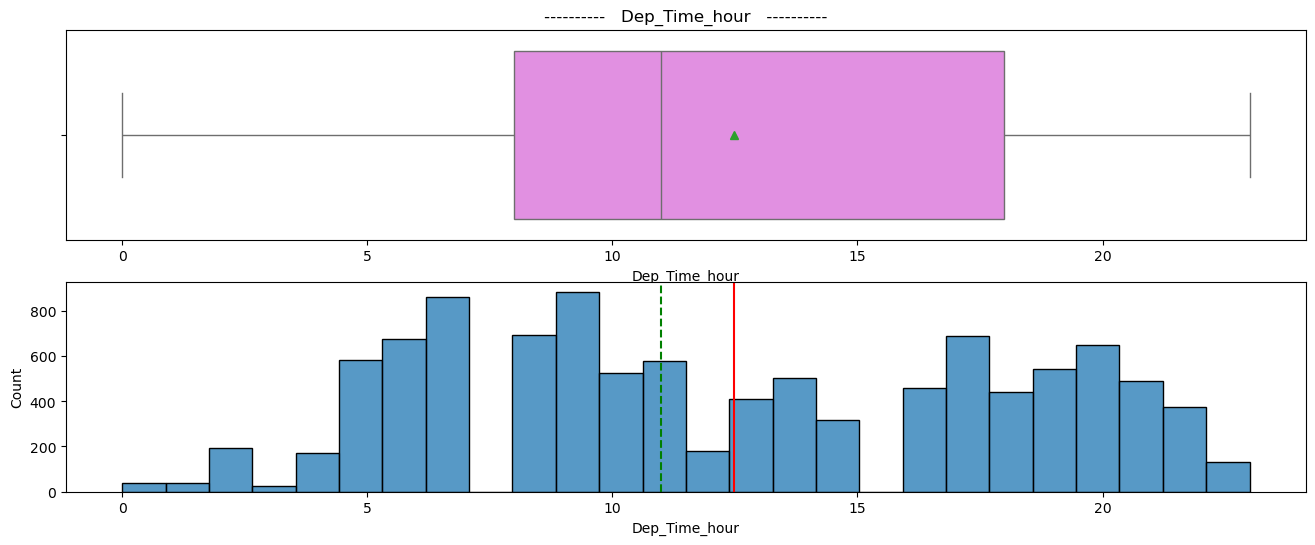

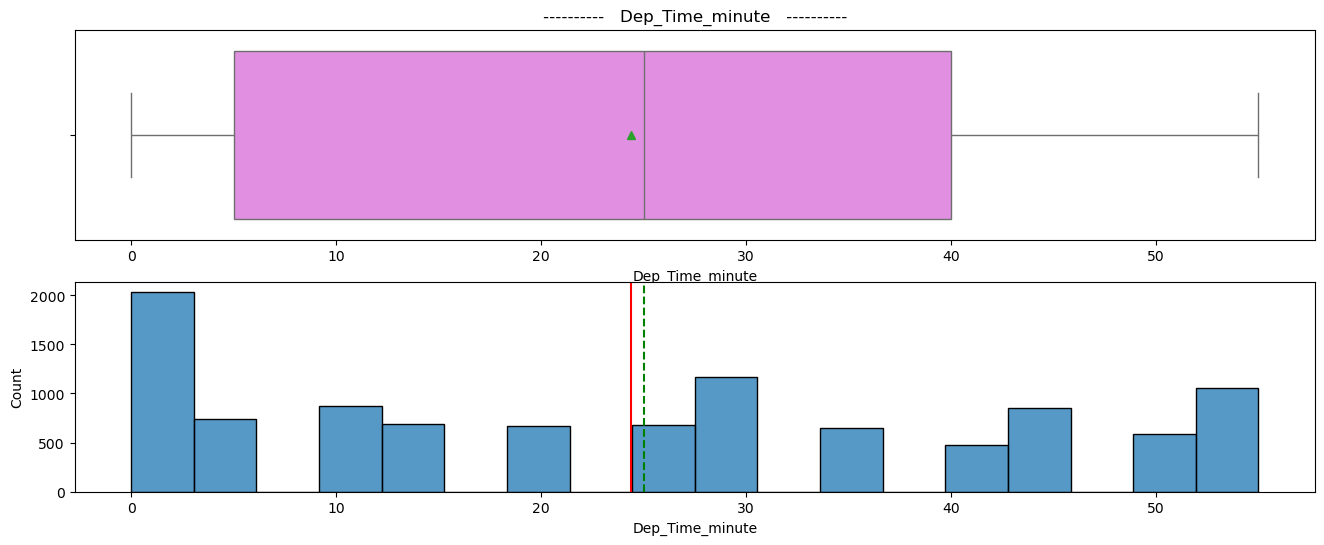

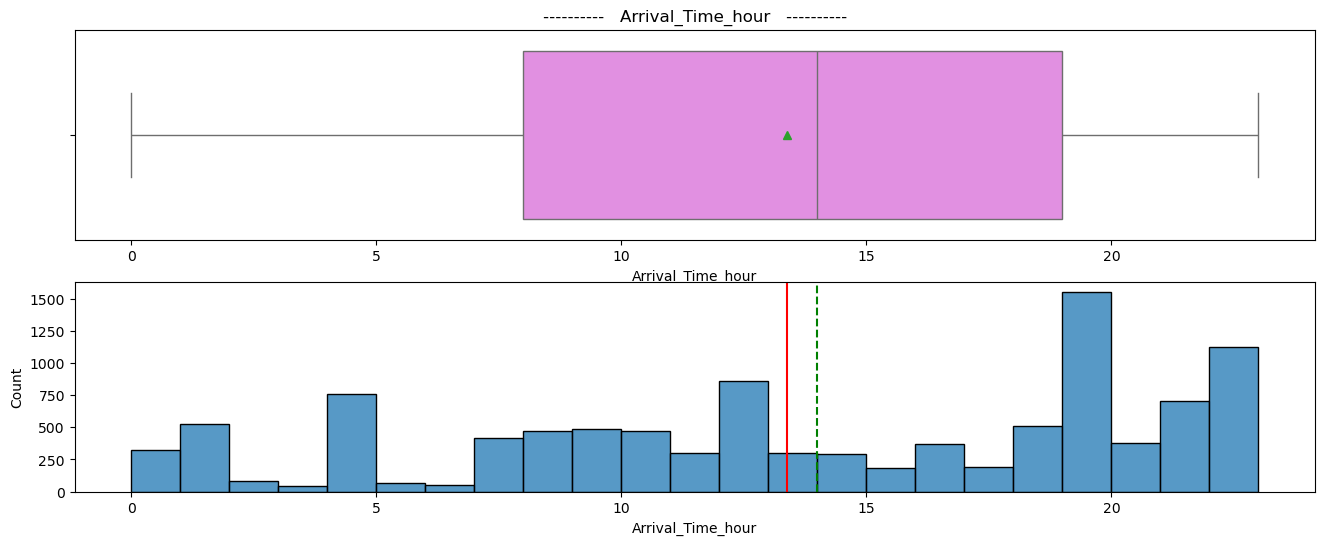

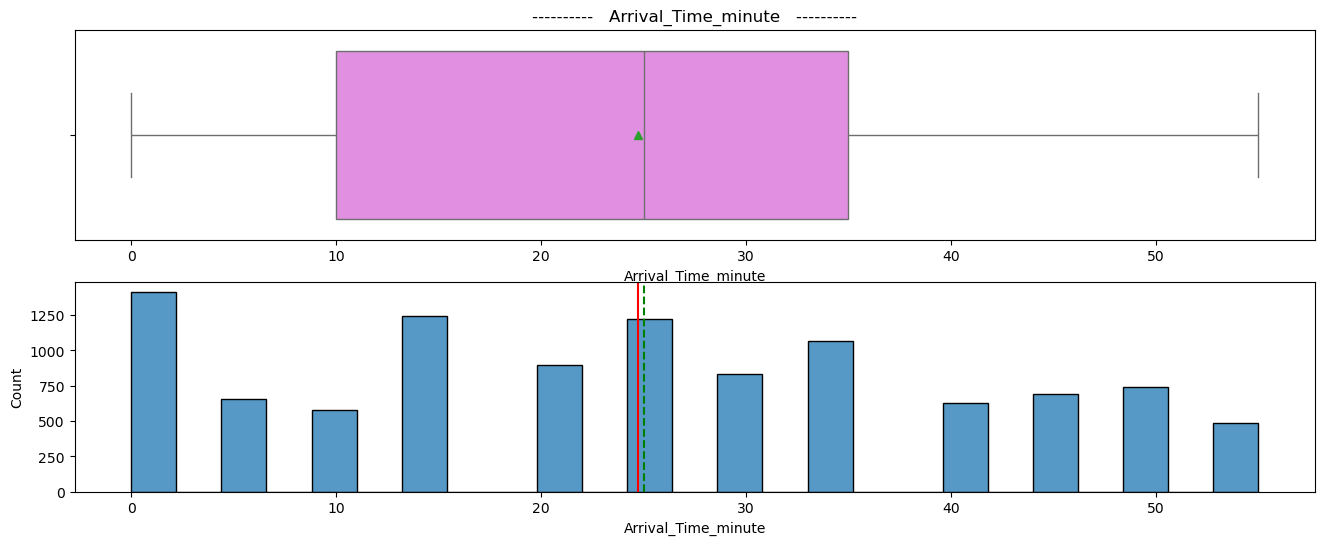

In [28]:
for col in numerical_columns:
    plt.figure(figsize=(16, 6))
    plt.subplot(2, 1, 1)
    plt.title("----------   " + col + "   ----------")
    sns.boxplot(data=data, x=col, showmeans=True, color="violet")
    plt.subplot(2, 1, 2)
    sns.histplot(data=data, x=col)
    plt.axvline(data[col].mean(), color="red", linestyle="-")
    plt.axvline(data[col].median(), color="green", linestyle="--")
    plt.show()

Let's take a look at the counts for the different categorical features.

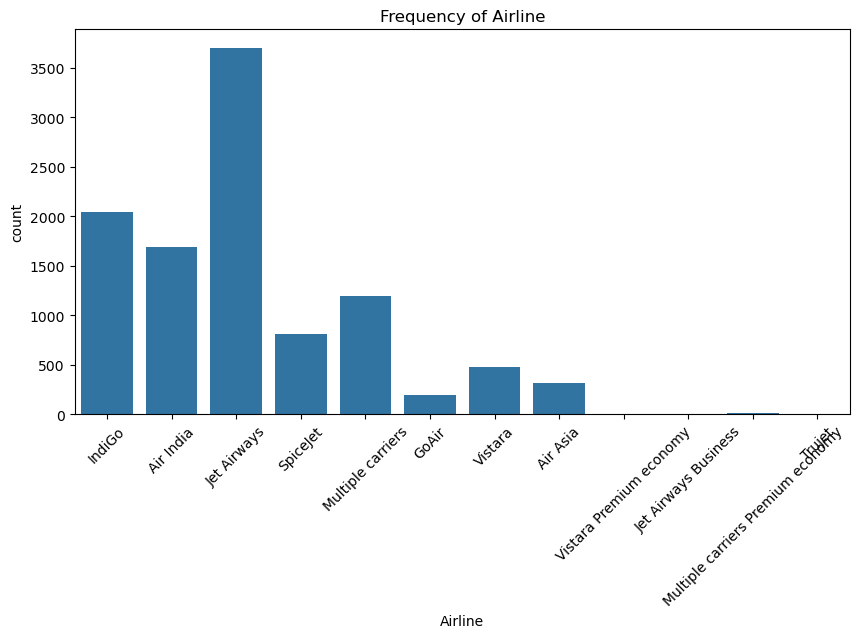

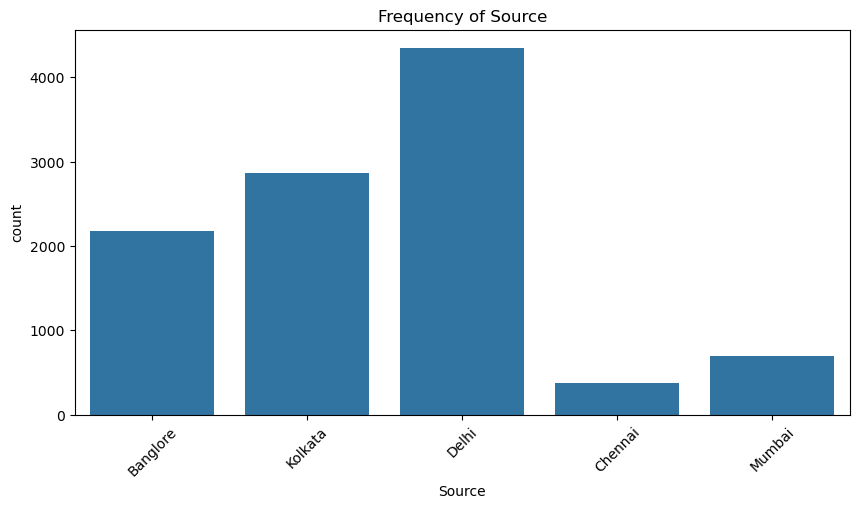

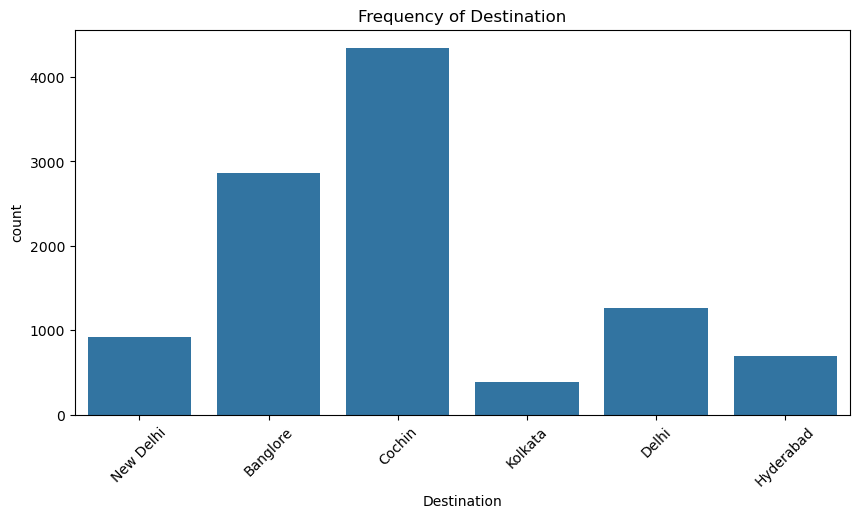

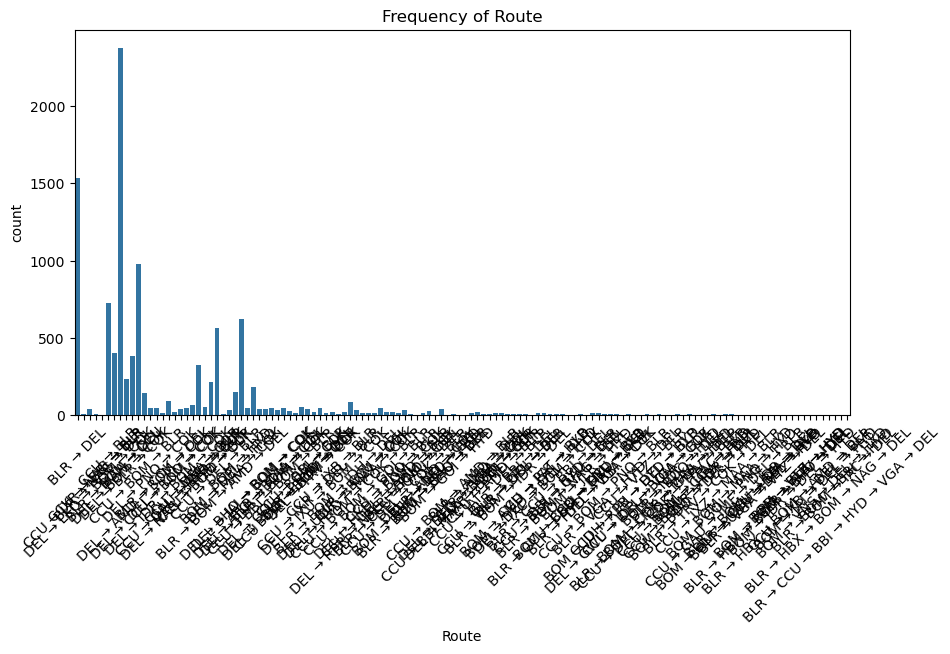

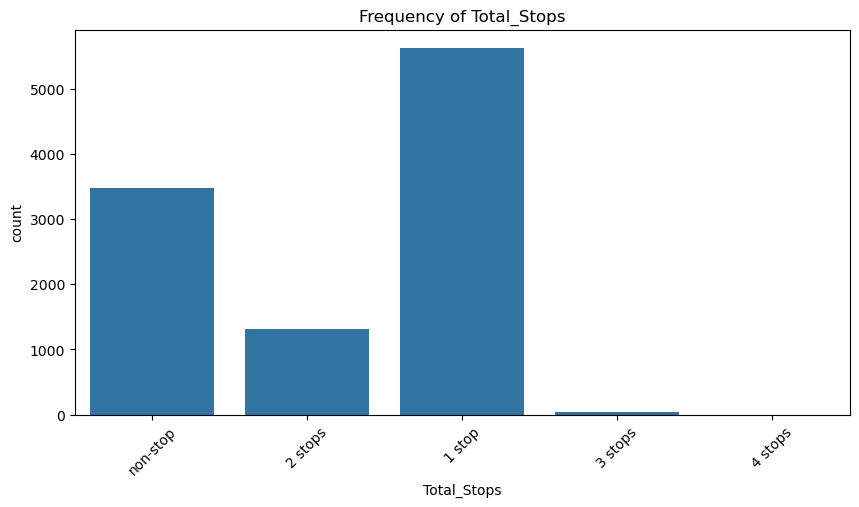

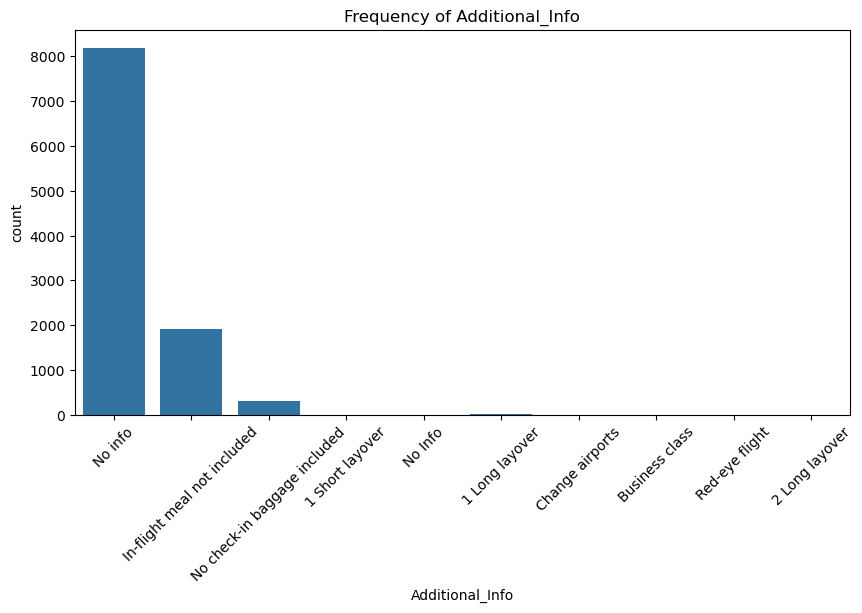

In [29]:
for col in categorical_columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=col, data=data)
    plt.title(f'Frequency of {col}')
    plt.xticks(rotation=45)
    plt.show()

What time of day do most flights leave?

In [30]:
def flight_dep_time(x):
    if (x>4) and (x<=8):
        return 'Early Morning'
    
    elif (x>8) and (x<=12):
        return 'Morning'
    
    elif (x>12) and (x<=16):
        return 'Noon'
    
    elif (x>16) and (x<=20):
        return 'Evening'
    
    elif (x>20) and (x<=24):
        return 'Night'
    else:
        return 'Late Night'

In [31]:
data['Dep_Time_hour'].apply(flight_dep_time).value_counts().iplot(kind='bar')

Does duration impact price or not?

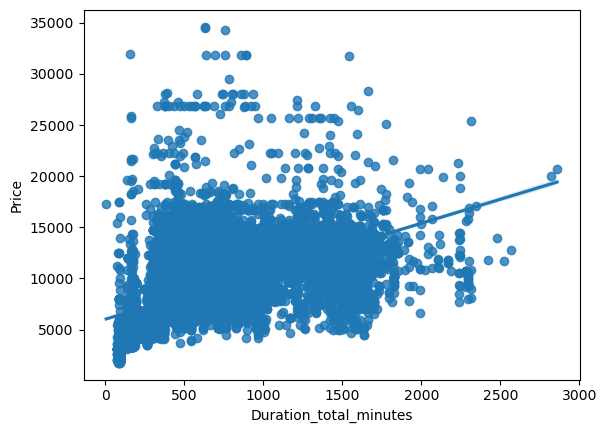

In [32]:
sns.regplot(x='Duration_total_minutes',
             y='Price',
             #ci=None,
             data=data)

plt.show()

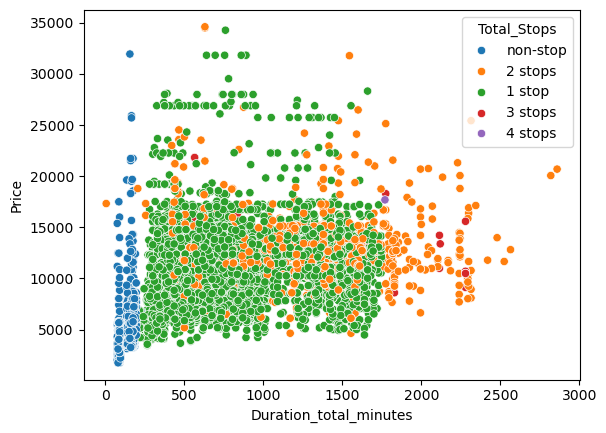

In [33]:
sns.scatterplot(x='Duration_total_minutes',
             y='Price',
             hue='Total_Stops',
             data=data)

plt.show()

What is the relationship between airlines and price?

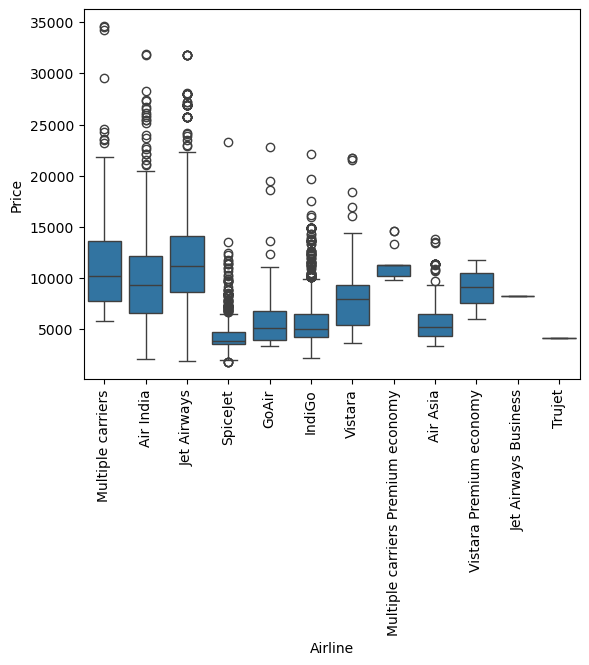

In [34]:
sns.boxplot(y='Price',
            x='Airline',
            data=data.sort_values('Price',ascending=False))

plt.xticks(rotation='vertical')
plt.show()

What is the highest routes taken on Jet Airways?

In [35]:
data[data['Airline'] == 'Jet Airways'].groupby('Route').size().sort_values(ascending=False)

Route
CCU → BOM → BLR          930
DEL → BOM → COK          875
BLR → BOM → DEL          385
BLR → DEL                381
CCU → DEL → BLR          300
BOM → HYD                207
DEL → JAI → BOM → COK    150
DEL → AMD → BOM → COK     94
DEL → IDR → BOM → COK     77
DEL → ATQ → BOM → COK     38
DEL → NAG → BOM → COK     34
DEL → COK                 34
DEL → BHO → BOM → COK     29
DEL → BDQ → BOM → COK     27
DEL → LKO → BOM → COK     25
DEL → JDH → BOM → COK     23
CCU → GAU → BLR           22
DEL → MAA → BOM → COK     11
DEL → IXC → BOM → COK     11
BLR → MAA → DEL           10
BLR → BDQ → DEL            8
DEL → UDR → BOM → COK      7
BOM → DEL → HYD            5
CCU → BOM → PNQ → BLR      4
BLR → BOM → JDH → DEL      3
DEL → DED → BOM → COK      2
BOM → BDQ → DEL → HYD      2
DEL → CCU → BOM → COK      1
BOM → VNS → DEL → HYD      1
BOM → UDR → DEL → HYD      1
BOM → JDH → DEL → HYD      1
BOM → IDR → DEL → HYD      1
BOM → DED → DEL → HYD      1
dtype: int64

Let's make a correlation matrix to see if any of the numerical features are correlated with ```Price```

In [36]:
numerical_col = numerical_columns.columns.to_list()

data[numerical_col].corr()['Price']

Price                     1.000000
Duration_total_minutes    0.537920
Duration_hour             0.540294
Duration_minute          -0.133865
Journey_day              -0.155628
Journey_month            -0.102506
Journey_year                   NaN
Dep_Time_hour             0.004446
Dep_Time_minute          -0.032949
Arrival_Time_hour         0.037774
Arrival_Time_minute      -0.090738
Name: Price, dtype: float64

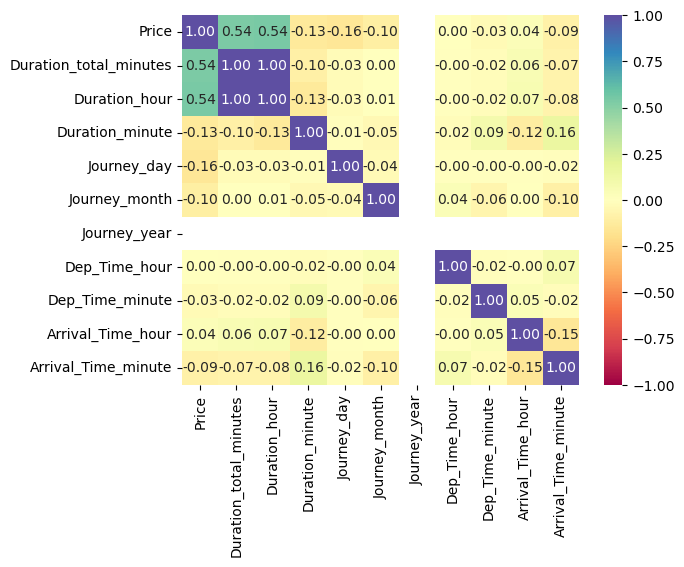

In [37]:
sns.heatmap(data[numerical_col].corr(),annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

# Feature Engineering

## Feature Selection

Let's take a look at any unecessary features that are either redundant or unimportant.

In [38]:
data['Additional_Info'].value_counts(normalize=True)

Additional_Info
No info                         0.782068
In-flight meal not included     0.184095
No check-in baggage included    0.030396
1 Long layover                  0.001816
Change airports                 0.000669
Business class                  0.000382
No Info                         0.000287
1 Short layover                 0.000096
Red-eye flight                  0.000096
2 Long layover                  0.000096
Name: proportion, dtype: float64

It looks like most of the information in ```Additional_Info``` is missing.

In [39]:
data['Journey_year'].unique()

array([2019])

Looks like ```Journey_year``` only captures one year.

In [40]:
data.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Duration_total_minutes,Duration_hour,Duration_minute,Journey_day,Journey_month,Journey_year,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897.0,170,2,50,24,3,2019,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662.0,445,7,25,1,5,2019,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882.0,1140,19,0,9,6,2019,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218.0,325,5,25,12,5,2019,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,13302.0,285,4,45,1,3,2019,16,50,21,35


It also looks like ```Route``` and ```Total_Stops``` capture the same information.

Let's go ahead and drop these three columns as they wouldn't provide any impactful information for the model.

In [41]:
y = data['Price']

drop = ['Route','Additional_Info','Journey_year','Price']
data.drop(columns=drop, inplace=True)

numerical_columns = data.select_dtypes(include=['number']).columns.to_list()

## One-Hot Encoding

Let's manually perform OHE on featues with a unique category size that is <= 10

In [42]:
ohe_columns = []
te_columns = []

for col in data.select_dtypes(include='object').columns:
    if data[col].nunique() <= 10:
        ohe_columns.append(col)
    else:
        te_columns.append(col)

# We wil label encode this later
ohe_columns.remove('Total_Stops')

In [43]:
for column in ohe_columns:
    for sub_category in data[column].unique():
        data[f'{column}_{sub_category}'] = data[column].apply(lambda x: 1 if x==sub_category else 0)
        
    data.drop(columns=column,inplace=True)

## Target Enconding

For everything >10 unique categories, let's manually perform Target Encoding.

In [44]:
for col in te_columns:
    target_mean = data.groupby(col).apply(lambda x: y.loc[x.index].mean())
    data[col + '_te'] = data[col].map(target_mean)
    data.drop(columns=col, inplace=True)

C:\Users\Devam\AppData\Local\Temp\ipykernel_10552\2534132956.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



## Label Encoding

Let's manually Label Encode ```Total_Stops```

In [45]:
data['Total_Stops'].unique()

array(['non-stop', '2 stops', '1 stop', '3 stops', '4 stops'],
      dtype=object)

In [46]:
total_stops_mapping = {'non-stop':0, '2 stops':2, '1 stop':1, '3 stops':3, '4 stops':4}

data['Total_Stops'] = data['Total_Stops'].map(total_stops_mapping)

In [47]:
data['Total_Stops'].value_counts()

Total_Stops
1    5625
0    3475
2    1318
3      43
4       1
Name: count, dtype: int64

Let's perform some scaling on the numerical columns of the data, normalization to be speciifc.

# Model Building

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

## Custom Functions and Train/Test Split

Define a funciton to calculate adjusted r2.

In [49]:
def adjusted_r2(r2,n,p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

Let's perform a train test split

In [50]:
X = data.copy()

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,random_state=42)

Define a predict function for quick evaluations of models

In [51]:
def predict(ml_model):
    # Fit the model
    model = ml_model.fit(X_train, y_train)
    
    # Print training score
    print('Training score : {}'.format(model.score(X_train, y_train)))
    
    # Make predictions on the test set
    y_prediction = model.predict(X_test)
    print('Predictions are : {}'.format(y_prediction))
    print('\n')
    
    # Calculate R-squared
    r2 = r2_score(y_test, y_prediction)
    
    # Calculate Adjusted R-squared
    n = X_test.shape[0]  # Number of observations
    p = X_train.shape[1]  # Number of explanatory variables (features)
    adj_r2 = adjusted_r2(r2, n, p)
    print('Adjusted R-squared : {}'.format(adj_r2))
    
    # Calculate MAE, MSE, RMSE
    mae = mean_absolute_error(y_test, y_prediction)
    mse = mean_squared_error(y_test, y_prediction)
    rmse = np.sqrt(mse)
    
    print('MAE : {}'.format(mae))
    print('MSE : {}'.format(mse))
    print('RMSE : {}'.format(rmse))
    
    # Plot the distribution of prediction errors
    sns.histplot(y_test - y_prediction)

## Linear Regression

Model before hyperparameter tuning.

Training score : 0.6038373606013816
Predictions are : [13897.48324472  4292.19733106  5008.20475885 ... 11669.04539855
 11240.33003445 11500.56378583]


Adjusted R-squared : 0.5822829868393345
MAE : 2017.0800012255759
MSE : 8201776.117340143
RMSE : 2863.874319403724


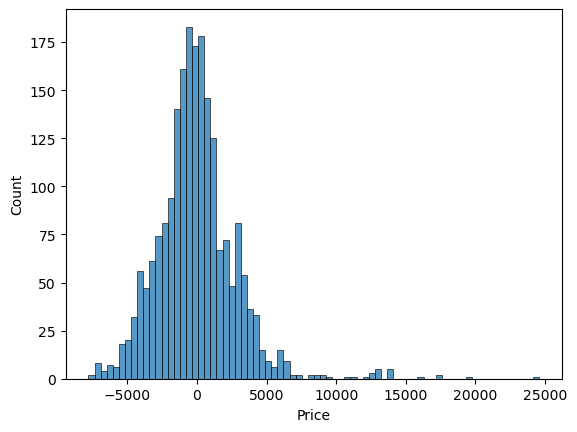

In [52]:
predict(LinearRegression())

Let's try an ElasticNet model to see if there are any improvements.

Fitting 5 folds for each of 70 candidates, totalling 350 fits
Training score : 0.6038356000145159
Predictions are : [13892.76052743  4291.31697502  5012.05642011 ... 11676.91906939
 11239.02929934 11497.713007  ]


Adjusted R-squared : 0.582213128416613
MAE : 2016.8654010273522
MSE : 8203147.7711752
RMSE : 2864.1137846068896


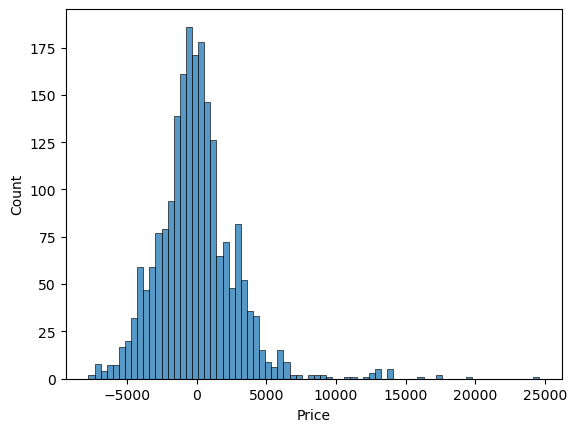

In [53]:
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],  
    'fit_intercept': [True, False],  
}

lr_grid = GridSearchCV(ElasticNet(max_iter=50000), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2).fit(X_train,y_train)
lr_grid_model = lr_grid.best_estimator_
predict(lr_grid_model)

## Decision Tree

Before hyperparameter tuning.

Training score : 0.9655006738032986
Predictions are : [14815.  3841.  4439. ... 10262.  6795. 13377.]


Adjusted R-squared : 0.6566086848448376
MAE : 1414.4853081700908
MSE : 6742408.374107474
RMSE : 2596.614791244068


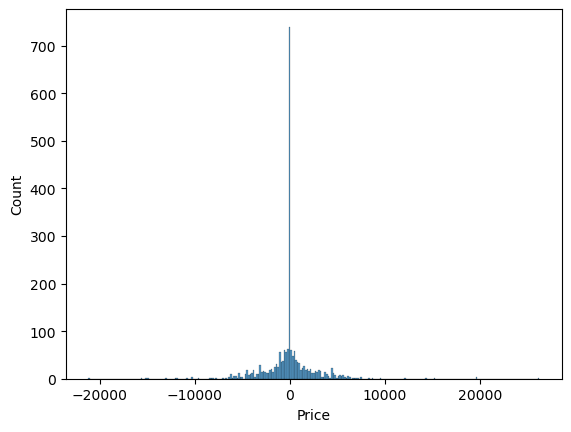

In [54]:
predict(DecisionTreeRegressor())

After hyperparameter tuning.

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
Training score : 0.8364452443125627
Predictions are : [14925.          3847.03174603  4049.48837209 ... 11971.72857143
  8695.875       8695.875     ]


Adjusted R-squared : 0.7698183936001917
MAE : 1318.798133137497
MSE : 4519562.149829888
RMSE : 2125.9261863549937


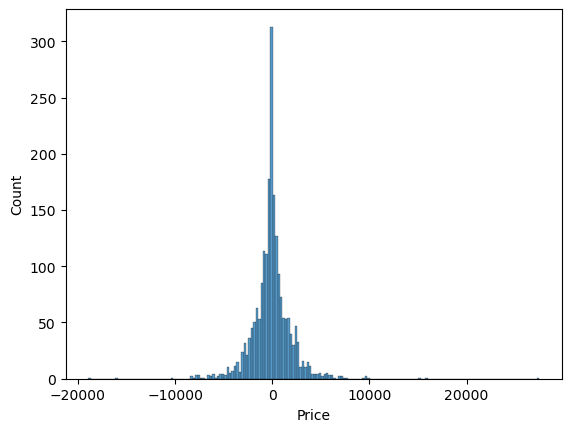

In [55]:
param_grid = {
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_leaf_nodes': [None, 10, 20, 50],
    'min_impurity_decrease': [0.0, 0.01, 0.1]
}

dt_grid = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, n_jobs=-1, verbose=2).fit(X_train,y_train)
dt_grid_model = dt_grid.best_estimator_
predict(dt_grid_model)

## Random Forest

Before hyperparameter tuning.

Training score : 0.9508163981884035
Predictions are : [14787.152       3841.14        4271.66533333 ... 11152.3325
  8048.715      12271.18      ]


Adjusted R-squared : 0.8100373517451902
MAE : 1183.2822321779324
MSE : 3729872.288069156
RMSE : 1931.2877279341772


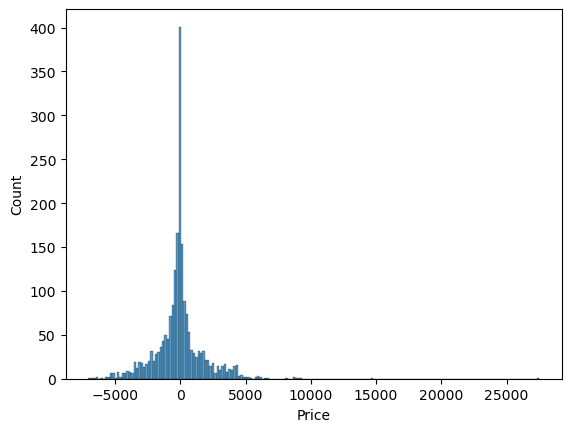

In [56]:
predict(RandomForestRegressor())

After hyperparameter tuning.

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Training score : 0.9164740209849098
Predictions are : [14718.99843473  3849.60257532  4317.70236394 ... 11149.13122209
  8559.67281571 11833.38647318]


Adjusted R-squared : 0.8356399620304028
MAE : 1129.3302548810104
MSE : 3227171.0071470486
RMSE : 1796.432856286883


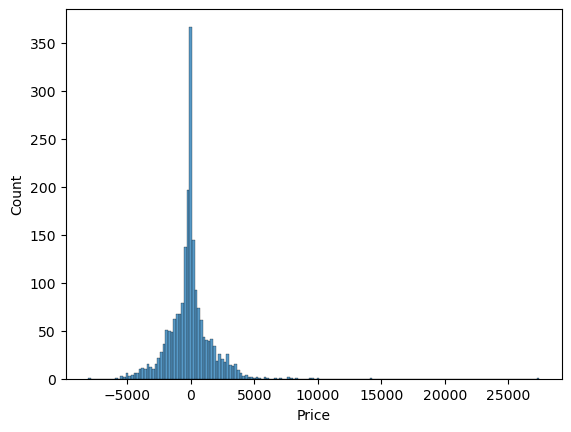

In [57]:
param_grid = {
    'max_depth':[None,10,20,30],
    'min_samples_split':[2,5,10],
    'n_estimators':[100,200,500]
}

rf_grid = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, n_jobs=-1, verbose=2).fit(X_train,y_train)
rf_grid_model = rf_grid.best_estimator_
predict(rf_grid_model)

## KNN

Before hyperparameter tuning.

Training score : 0.8326795067182164
Predictions are : [14415.8  3847.4  4336.8 ... 10222.2 10430.6 11747. ]


Adjusted R-squared : 0.7571518395402815
MAE : 1430.6462494027712
MSE : 4768266.984214046
RMSE : 2183.6361840320483


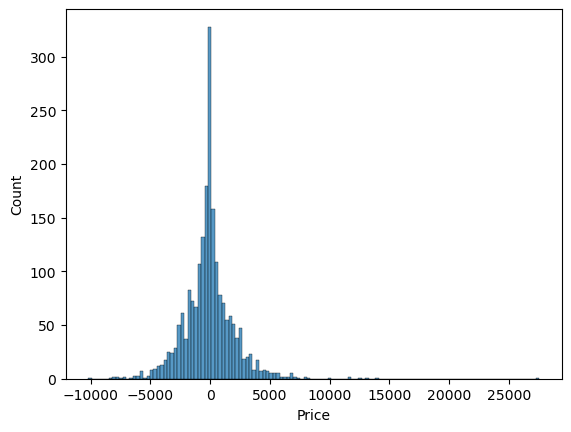

In [58]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

predict(KNeighborsRegressor())

After hyperparameter tuning.

Fitting 5 folds for each of 112 candidates, totalling 560 fits
Training score : 0.8324575562165002
Predictions are : [13932.8  3847.4  4274.  ... 10684.2 10786.2 12442.8]


Adjusted R-squared : 0.7396030478974212
MAE : 1420.3551839464885
MSE : 5112833.414715719
RMSE : 2261.157538676976


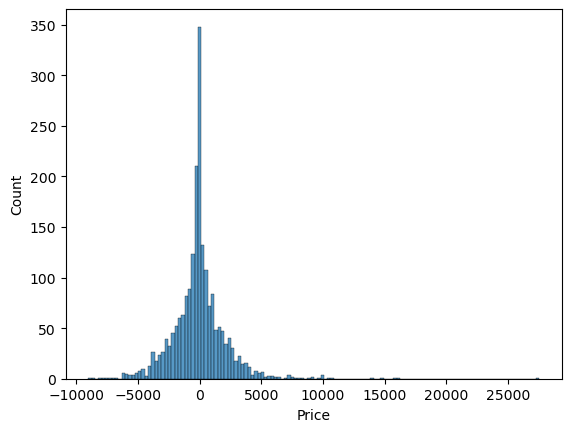

In [59]:
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 10, 15, 20],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

kn_grid = GridSearchCV(KNeighborsRegressor(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2).fit(X_train, y_train)
kn_grid_model = kn_grid.best_estimator_
predict(kn_grid_model)

## SVM

Before hyperparameter tuning.

Training score : 0.0684026425092078
Predictions are : [8327.43090202 7855.43427454 7820.13409297 ... 8591.22407765 8516.39197615
 8436.92466231]


Adjusted R-squared : 0.0611454480223963
MAE : 3332.013380807558
MSE : 18434190.13221817
RMSE : 4293.505576125198


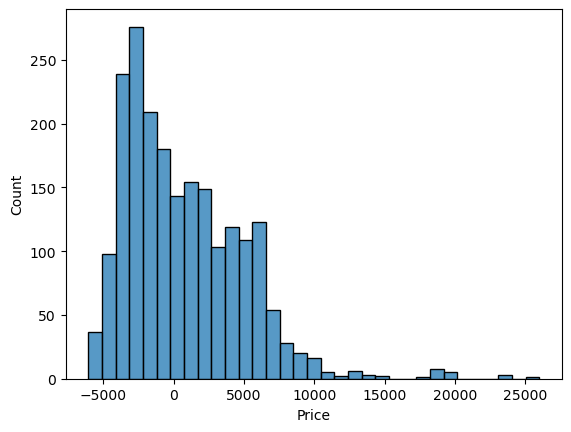

In [60]:
predict(SVR())

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Training score : 0.5670546530491865
Predictions are : [11524.3897371   4114.0664804   4698.91988726 ... 10680.54866642
 10647.74667185 10275.8059584 ]


Adjusted R-squared : 0.5467172760220206
MAE : 1913.7586903338004
MSE : 8900100.553231562
RMSE : 2983.303630747558


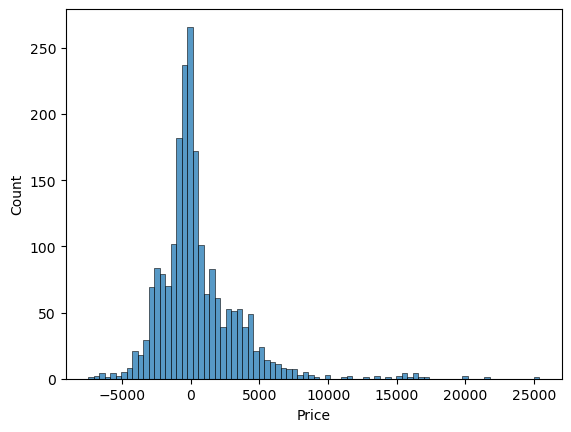

In [61]:
param_grid = {
    'C': [0.1, 1, 10, 50],
    'epsilon': [0.01, 0.1, 1, 10],
    'gamma':['scale',0.01,0.1],
}

svm_grid = GridSearchCV(SVR(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2).fit(X_train, y_train)
svm_grid_model = svm_grid.best_estimator_
predict(svm_grid_model)

## Artifact Creation of best model

It looks like the best model by far is a tuned RandomForest model. Let's save this model as a pickle file.

In [63]:
import pickle
import os

In [64]:
artifacts_dir = 'artifacts'
if not os.path.exists(artifacts_dir):
	os.makedirs(artifacts_dir)

# Save final model and artifacts
artifacts_dict = {
	'best_model': rf_grid_model 
}

with open(os.path.join(artifacts_dir, 'artifacts.pkl'), 'wb') as artifacts_dict_file:
	pickle.dump(artifacts_dict, artifacts_dict_file)